In [1]:
import sys
from os import getcwd, pardir
from os.path import join, abspath

parent_path = abspath(join(getcwd(), pardir))
sys.path.append(parent_path)

In [2]:
# Imports
from datetime import datetime
from constants import *
import mdb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Global vars and inputs
trading_days_per_yr = 252
mkt = 'us'
ticker = '_GSPC'
db_name = mdb.db_to_use(mkt)
coll_name = ticker
today = datetime.utcnow()
date_range_start = '2000-01-01'
date_range_end = None

In [4]:
# Calculate Date range
start_date = datetime.strptime(date_range_start, DATE_FORMAT)
end_date = datetime.strptime(date_range_end, DATE_FORMAT) \
    if date_range_end \
    else datetime(today.year, today.month, today.day)

# start_date, end_date

In [5]:
# DB Query
filter = { 'date': { '$gt': start_date, '$lt': end_date } }
projection = { '_id': 0 }
sort = [( 'date', 1 )]

In [6]:
# Part 1: Get the data
records = mdb.find_records(db_name, coll_name, filter=filter, projection=projection, sort=sort)
df = pd.DataFrame(list(records))
df.shape

(5154, 7)

In [7]:
# Part 2: Calculate the inputs that go into the model
df['% change'] = df['close'].pct_change()
df['200 sma'] = df['close'].rolling(window=200).mean().round(5)
df['50 sma'] = df['close'].rolling(window=50).mean().round(5)

### Model 1

* Go long if the price is above the 200sma
* Sell if the price falls below the 200sma

### Model 2

* Go long if the 50sma crosses above the 200sma or when the price is above 200sma
* Sell if the 50sma falls below 200sma and the price is below the 200sma

In [8]:
# Part 3: Models' Criteria

df['M1'] = df['close'] >= df['200 sma']
df['M2'] = (df['50 sma'] >= df['200 sma']) | df['M1'] == True

In [9]:
# Part 4: Calculate the models

model_0 = 'Buy and hold'
model_1 = '200 sma model'
model_2 = '200 sma + crossover model'

df[model_0] = 100*(1+df['% change']).cumprod()
df[model_1] = 100*(1+df['M1'].shift(1)*df['% change']).cumprod()
df[model_2] = 100*(1+df['M2'].shift(1)*df['% change']).cumprod()

In [10]:
# Part 5: Calculate the models' returns

years = (df['date'].count()+1-200) / trading_days_per_yr

# buy and hold's returns
model_0_start = df['close'].iloc[200]
model_0_end = df['close'].iloc[-1]
model_0_avg_return = (model_0_end/model_0_start) ** (1/years)-1
print(f'{model_0} yields an average of {(model_0_avg_return*100).round(3)}% per year')

# 200 sma model's returns
model_1_start = df[model_1].iloc[200]
model_1_end = df[model_1].iloc[-1]
model_1_avg_return = (model_1_end/model_1_start) ** (1/years)-1
print(f'{model_1} yields an average of {(model_1_avg_return*100).round(3)}% per year')

# 200 sma + crossover model's returns
model_2_start = df[model_2].iloc[200]
model_2_end = df[model_2].iloc[-1]
model_2_avg_return = (model_2_end/model_2_start) ** (1/years)-1
print(f'{model_2} yields an average of {(model_2_avg_return*100).round(3)}% per year')



Buy and hold yields an average of 4.161% per year
200 sma model yields an average of 3.393% per year
200 sma + crossover model yields an average of 4.601% per year


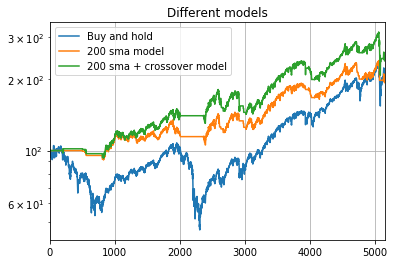

In [11]:
# Part 6: Plot the models
df[[model_0, model_1, model_2]].plot(grid=True, kind='line', title='Different models', logy=True)